In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
from numpy import radians, sin, cos, arcsin, sqrt
def dist(a, b):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    x1, y1, x2, y2 = map(radians, [a[0], a[1], b[0], b[1]])
    dx = x2 - x1
    dy = y2 - y1
    a = sin(dy/2)**2 + cos(y1) * cos(y2) * sin(dx/2)**2
    c = 2 * arcsin(sqrt(a))
    # Earth`s radius in kilometers
    km = 6372.795 * c
    return km

In [4]:
plt.style.use('Solarize_Light2')   # try another styles: 'classic'
plt.rcParams['figure.figsize'] = [15, 15]
driver = '~/'
pwd = f"{driver}1_Data1/sea/"
destData = f"{pwd}AllSeaGisOut.txt"
obrisData = f"{driver}1_Data1/obris/obris.dat"
batimetrFile = f"{driver}1_Data1/batimetria/b1.txt"
# srcData = "~/methaneSea.dat

In [5]:
df = pd.read_csv( f"{pwd}AllSea.txt",
                 header=0,
                 # skip_blank_lines=True,
                 skipinitialspace=True,
                 na_values='--',
                 #kiprows=[1,2,3,4],
                 sep='\t',
                 decimal=',',
                 # nrows=100000,
                 parse_dates=['DateTime'],
                 dayfirst=True
                 )

In [7]:
df.describe()

,DateTime,Longitude,Latitude,TempAir,PressAir,TempWtr,pCO2Air,pCH4Air,pCO2Wtr,pCH4Wtr,dpCO2,dpCH4,cCO2Wtr,cCH4Wtr
count,316393,315941.000000,315937.000000,254747.000000,308693.000000,308034.000000,150046.000000,133000.000000,206882.000000,201706.000000,207659.000000,201703.000000,202621.000000,196730.000000
mean,2018-08-13 21:57:54.506888448,107.177013,53.172081,8.564898,95838.703644,3.392567,397.807095,1.901143,376.102368,7.201778,-17.814995,5.329515,1.106823,260.549049
min,2013-05-28 22:00:38,103.752400,51.510378,1.140000,94508.200000,0.310000,374.134608,1.784661,-43.555232,-16.445101,-434.382825,-18.290101,-0.106492,-593.397735
25%,2016-06-02 05:39:49,105.466200,51.898006,6.100000,95643.100000,2.630000,393.168864,1.874122,314.894659,2.601381,-80.158876,0.746021,0.936195,96.995808
50%,2018-05-26 05:36:01,107.529274,53.035725,8.075000,95725.500000,3.100000,397.934495,1.885096,365.742239,3.429917,-28.996291,1.571630,1.087626,132.867344
75%,2021-06-07 17:10:52,108.819828,54.010496,10.280000,96147.000000,3.690000,402.190062,1.924664,431.966558,5.076149,36.813528,3.206267,1.275232,192.982289
max,2022-06-14 03:41:42,109.870200,55.768120,35.100000,97183.300000,18.940000,498.478063,6.846149,1954.766673,589.383791,1552.266673,587.516991,4.105349,18500.433975
std,NaN,1.830315,1.268843,3.531095,447.189124,1.564947,7.347957,0.067843,121.731738,19.846490,121.506108,19.830777,0.345656,640.728093


In [15]:
dfjun23 = pd.read_csv(f'{pwd}BaikalJun2023Sea.dat',
                      header=0, 
                      # skip_blank_lines=True, 
                      skipinitialspace=True,
                      na_values='--',
                      skiprows=[1,2,3,4],
                      sep='\t',
                      decimal=',',
                      # nrows=100000,
                      parse_dates=['DateTime'],
                      dayfirst=True,
)
dfjun23.describe()

,DateTime,Unnamed: 1,Speed,Course,AirFlow,TempAir,PressAir,Precipitation,LightLX,LightUV,...,pCO2Air,pCH4Air,dTSec,cCO2Wtr,pCO2Wtr,cCH4Wtr,pCH4Wtr,dpCO2,pCO2,pCH4
count,64962,64962.000000,63981.000000,63976.000000,64755.000000,64006.00000,64007.000000,64005.000000,64008.000000,64007.000000,...,64001.000000,64001.000000,64962.0,45922.000000,45922.000000,45849.000000,45849.000000,45922.000000,64007.000000,64007.000000
mean,2023-06-07 06:20:10,32482.500000,2.264360,104.960793,0.929766,12.29334,0.948737,0.149980,233.550230,0.016112,...,408.369380,1.912146,20.0,1.079722,364.810868,311.352865,9.223146,-37.189132,386.236514,2.396948
min,2023-05-30 17:53:20,2.000000,0.017000,0.000000,0.090860,5.10136,0.936383,0.000000,0.000000,0.000000,...,393.308508,1.878275,20.0,0.221903,90.726418,50.681656,1.385534,-311.273582,150.306069,1.876440
25%,2023-06-03 12:06:45,16242.250000,0.196000,0.000000,0.909651,9.67067,0.946426,0.000000,0.102888,0.000000,...,402.515057,1.901812,20.0,0.846102,272.555487,100.818835,2.650899,-129.444513,326.652615,1.942875
50%,2023-06-07 06:20:10,32482.500000,2.929730,51.065550,0.919156,11.60110,0.948973,0.000000,90.152752,0.006140,...,407.438749,1.908675,20.0,1.138037,380.889940,126.677363,3.363523,-21.110060,400.763885,2.004748
75%,2023-06-11 00:33:35,48722.750000,4.167870,211.218250,0.928795,14.47475,0.951200,0.000000,358.210288,0.021794,...,412.630709,1.916259,20.0,1.356668,456.566234,207.674485,5.625032,54.566234,433.247934,2.142312
max,2023-06-14 18:47:00,64963.000000,4.664000,359.778000,1.082750,27.85180,0.957547,4.250000,1103.951658,1.065798,...,471.708237,2.284426,20.0,3.537280,1537.131623,42910.531053,1415.333795,1135.131623,1270.137841,288.540745
std,NaN,18753.058431,1.818209,118.143943,0.036938,3.59907,0.003941,0.679692,298.773227,0.044416,...,8.600092,0.020598,0.0,0.383228,127.174721,814.003370,25.708021,127.174721,78.590392,2.810068


In [16]:
dfjun24 = pd.read_csv(f'{pwd}BaikalJun2024Sea.dat',
                      header=0, 
                      # skip_blank_lines=True, 
                      skipinitialspace=True,
                      na_values='--',
                      skiprows=[1,2,3,4],
                      sep='\t',
                      decimal='.',
                      # nrows=100000,
                      parse_dates=['DateTime'],
                      dayfirst=False,
)

In [17]:
dfjun24.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83052 entries, 0 to 83051
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       83052 non-null  datetime64[ns]
 1   DateTime.1     83052 non-null  object        
 2   hour           83052 non-null  int64         
 3   DateSec        83052 non-null  int64         
 4   TempAir        66030 non-null  float64       
 5   PressAir       66030 non-null  float64       
 6   Precipitation  66030 non-null  float64       
 7   LightLX        66030 non-null  float64       
 8   LightUV        66030 non-null  float64       
 9   Latitude       65818 non-null  float64       
 10  Longitude      65818 non-null  float64       
 11  vCO2           62144 non-null  float64       
 12  vCH4           62144 non-null  float64       
 13  vH2O           62120 non-null  float64       
 14  AirFlow        66263 non-null  float64       
 15  Channel        8305

In [18]:
df.shape, df.columns

((316393, 14),
 Index(['DateTime', 'Longitude', 'Latitude', 'TempAir', 'PressAir', 'TempWtr',
        'pCO2Air', 'pCH4Air', 'pCO2Wtr', 'pCH4Wtr', 'dpCO2', 'dpCH4', 'cCO2Wtr',
        'cCH4Wtr'],
       dtype='object'))

In [19]:
df = pd.concat([df, dfjun23, dfjun24])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 464407 entries, 0 to 83051
Data columns (total 51 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   DateTime       464407 non-null  datetime64[ns]
 1   Longitude      445740 non-null  float64       
 2   Latitude       445739 non-null  float64       
 3   TempAir        384783 non-null  float64       
 4   PressAir       438730 non-null  float64       
 5   TempWtr        308034 non-null  float64       
 6   pCO2Air        278077 non-null  float64       
 7   pCH4Air        261040 non-null  float64       
 8   pCO2Wtr        294509 non-null  float64       
 9   pCH4Wtr        289427 non-null  float64       
 10  dpCO2          253581 non-null  float64       
 11  dpCH4          201703 non-null  float64       
 12  cCO2Wtr        290248 non-null  float64       
 13  cCH4Wtr        284451 non-null  float64       
 14  Unnamed: 1     64962 non-null   float64       
 15  Speed 

In [20]:
df['year'] = df['DateTime'].dt.year

In [21]:
df.reset_index(drop=True, inplace=True)
df

,DateTime,Longitude,Latitude,TempAir,PressAir,TempWtr,pCO2Air,pCH4Air,pCO2Wtr,pCH4Wtr,...,vCO2Air_a,vCH4Air,dTSec,pCO2,pCH4,DateTime.1,hour,DateSec,WaterFlowEqu4,year
0,2013-05-28 22:00:38,104.649879,51.781395,NaN,NaN,3.0,402.425575,NaN,464.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
1,2013-05-28 22:01:38,104.649879,51.781395,NaN,NaN,3.0,402.425706,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
2,2013-05-28 22:02:38,104.649879,51.781395,NaN,NaN,3.0,402.425837,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
3,2013-05-28 22:03:38,104.649879,51.781395,NaN,NaN,3.0,402.425968,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
4,2013-05-28 22:04:38,104.649879,51.781395,NaN,NaN,3.0,402.426099,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464402,2024-06-12 19:16:20,105.044195,51.878914,18.06,0.945167,NaN,398.430013,1.896581,NaN,NaN,...,NaN,2.00661,NaN,398.689788,1.898499,2024-06-12 19:16:20,19.0,1.718220e+09,NaN,2024
464403,2024-06-12 19:16:40,105.043188,51.878469,18.10,0.945124,NaN,398.481455,1.896495,NaN,NaN,...,NaN,2.00661,NaN,398.050635,1.897455,2024-06-12 19:16:40,19.0,1.718220e+09,NaN,2024
464404,2024-06-12 19:17:00,105.042178,51.878013,18.12,0.945118,NaN,398.339389,1.896484,NaN,NaN,...,NaN,2.00661,NaN,398.300636,1.898402,2024-06-12 19:17:00,19.0,1.718220e+09,NaN,2024
464405,2024-06-12 19:17:20,105.041126,51.877511,18.06,0.945102,NaN,398.161076,1.896452,NaN,NaN,...,NaN,2.00661,NaN,398.147755,1.897411,2024-06-12 19:17:20,19.0,1.718220e+09,NaN,2024


In [22]:
df = df.dropna(axis='index', subset=['Longitude', 'Latitude', 'cCO2Wtr', 'cCH4Wtr'], inplace=False)
dfco2 = df.dropna(axis='index', subset=['Longitude', 'Latitude', 'cCO2Wtr'], inplace=False)
dfch4 = df.dropna(axis='index', subset=['Longitude', 'Latitude', 'cCH4Wtr'], inplace=False)
dfco2.shape, dfch4.shape

((282731, 52), (282731, 52))

In [23]:
for yr in range(2013, 2026):
    t = dfco2.loc[(df['year'] == yr) & df['cCO2Wtr']].shape
    print(f'{yr}: {t[0]}')

2013: 11610
2014: 0
2015: 0
2016: 72915
2017: 15972
2018: 30267
2019: 0
2020: 0
2021: 32634
2022: 32074
2023: 45844
2024: 41415
2025: 0


In [24]:
for yr in range(2013, 2026):
    t = dfch4.loc[(df['year'] == yr) & df['cCH4Wtr']].shape
    print(f'{yr}: {t[0]}')

2013: 11610
2014: 0
2015: 0
2016: 72915
2017: 15972
2018: 30267
2019: 0
2020: 0
2021: 32634
2022: 32074
2023: 45844
2024: 41415
2025: 0


In [25]:
obris = pd.read_csv(obrisData,
                    header=0,
                    na_values='--',
                    sep='\t',
                    decimal=',',
                    )
obris.head(3)

,i,long,lat
0,1,NaN,NaN
1,2,109.004,53.667
2,3,109.008,53.665


In [26]:
batlegend = pd.read_csv(batimetrFile,
                         nrows=6,
                         decimal='.',
                         sep='\s+',
                         index_col=0,
                         header=None,
                        )
batlegend= batlegend.T
na_val = batlegend['nodata_value']

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\redmi\AppData\Local\Temp\ipykernel_30520\2360301572.py:4: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


In [27]:
batimetria = pd.read_csv(batimetrFile,
                         skiprows=6,
                         decimal='.',
                         sep='\s+',
                         na_values=na_val,
                         index_col=False,
                         header=None,
                        )

# batimetria.dtypes\
xllcorner = batlegend.loc[1, 'xllcorner']
yllcorner = batlegend.loc[1, 'yllcorner']
cellsize = batlegend.loc[1, 'cellsize']

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\redmi\AppData\Local\Temp\ipykernel_30520\2203193226.py:4: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


In [28]:
batimetria

,0,1,2,3,4,5,6,7,8,9,...,971,972,973,974,975,976,977,978,979,980
0,92.576,94.269,108.308,140.394,155.421,155.106,144.943,137.127,141.174,143.030,...,532.961,591.498,635.591,629.861,594.416,539.309,465.849,401.920,356.955,331.500
1,117.490,104.356,104.952,131.331,144.203,151.932,153.099,141.359,132.443,125.223,...,491.681,490.450,450.109,422.973,390.435,354.914,317.130,331.771,331.940,320.415
2,115.405,112.536,112.069,116.328,136.226,149.817,153.153,131.779,129.614,133.314,...,310.936,273.969,231.724,253.108,274.492,264.423,197.384,204.558,218.024,231.329
3,164.047,148.946,133.204,122.235,141.075,155.332,161.629,148.051,145.746,147.565,...,210.257,200.681,188.991,197.135,213.774,215.040,183.526,166.477,184.008,222.164
4,141.831,148.086,147.116,132.823,153.363,167.668,174.336,167.233,164.650,162.399,...,142.300,159.968,172.054,161.329,165.193,170.199,168.804,117.707,96.929,101.755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1458.321,1427.508,1390.659,1356.388,1350.551,1402.535,1469.104,1432.390,1466.292,1515.823,...,643.498,621.276,599.225,630.598,617.128,587.394,554.248,597.357,593.418,555.245
696,1672.016,1551.782,1414.966,1298.768,1276.010,1305.206,1350.353,1315.306,1339.346,1382.754,...,639.675,613.279,581.924,593.696,597.876,585.903,549.083,594.966,629.153,647.412
697,1550.746,1522.785,1446.082,1306.210,1243.820,1235.192,1253.770,1233.823,1265.851,1309.578,...,647.277,613.908,571.063,554.631,574.938,578.363,529.876,551.517,563.083,563.671
698,1476.661,1495.463,1492.878,1450.758,1305.566,1200.301,1165.882,1312.543,1435.477,1521.380,...,638.956,605.026,552.034,517.050,531.772,546.461,532.223,488.027,460.900,450.586


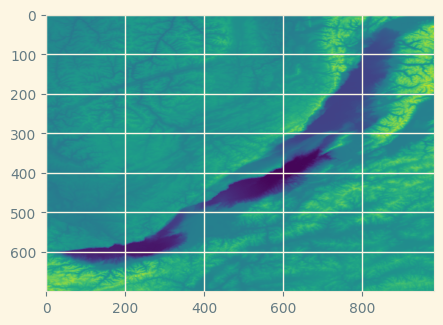

In [29]:
plt.rcParams['figure.figsize'] = [5, 6]
plt.imshow(batimetria)

In [30]:
#df['depth'] = batimetria.iloc[((df['Latitude'] - yllcorner) / cellsize).astype('int32'),((df['Longitude'] - xllcorner) / cellsize).astype('int32')]
yllcorner_m = yllcorner + batimetria.shape[0] * cellsize
yllcorner_m

55.99940106775059

In [31]:
df['batiy'] = ((yllcorner_m - df['Latitude']) / cellsize).astype('int32')
df['batix'] = ((df['Longitude'] - xllcorner) / cellsize).astype('int32')
df.dtypes

C:\Users\redmi\AppData\Local\Temp\ipykernel_30520\206162316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['batiy'] = ((yllcorner_m - df['Latitude']) / cellsize).astype('int32')
C:\Users\redmi\AppData\Local\Temp\ipykernel_30520\206162316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['batix'] = ((df['Longitude'] - xllcorner) / cellsize).astype('int32')


DateTime         datetime64[ns]
Longitude               float64
Latitude                float64
TempAir                 float64
PressAir                float64
TempWtr                 float64
pCO2Air                 float64
pCH4Air                 float64
pCO2Wtr                 float64
pCH4Wtr                 float64
dpCO2                   float64
dpCH4                   float64
cCO2Wtr                 float64
cCH4Wtr                 float64
Unnamed: 1              float64
Speed                   float64
Course                  float64
AirFlow                 float64
Precipitation           float64
LightLX                 float64
LightUV                 float64
WaterFlowEqu1           float64
WaterFlowEqu2           float64
WaterFlowEqu3           float64
TempEqu1                float64
TempEqu2                float64
TempEqu3                float64
EKV_4_TEMP              float64
vCO2                    float64
vCH4                    float64
vH2O                    float64
FluoNxRe

In [32]:
a = ((yllcorner_m - df['Latitude']) / cellsize).astype('int16')
a

76        600
77        600
78        600
79        600
80        601
         ... 
464174    575
464175    574
464176    574
464177    574
464178    574
Name: Latitude, Length: 282731, dtype: int16

In [33]:
#df = (pd.merge(df, batimetria.stack().rename("depth"), left_on=["batiy", "batix"], right_index=True, how="left"))
df['depth'] = batimetria.to_numpy()[df['batiy'], df['batix']]
df

C:\Users\redmi\AppData\Local\Temp\ipykernel_30520\1140197561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depth'] = batimetria.to_numpy()[df['batiy'], df['batix']]


,DateTime,Longitude,Latitude,TempAir,PressAir,TempWtr,pCO2Air,pCH4Air,pCO2Wtr,pCH4Wtr,...,pCO2,pCH4,DateTime.1,hour,DateSec,WaterFlowEqu4,year,batiy,batix,depth
76,2013-05-29 00:39:44,104.366131,51.708487,NaN,NaN,3.0,402.451705,NaN,NaN,2.504781,...,NaN,NaN,NaN,NaN,NaN,NaN,2013,600,121,-1339.443
77,2013-05-29 00:40:44,104.362324,51.708268,NaN,NaN,3.0,402.451719,NaN,464.380000,2.535802,...,NaN,NaN,NaN,NaN,NaN,NaN,2013,600,121,-1339.443
78,2013-05-29 00:41:44,104.358530,51.708036,NaN,NaN,3.0,402.451733,NaN,NaN,2.550802,...,NaN,NaN,NaN,NaN,NaN,NaN,2013,600,120,-1340.690
79,2013-05-29 00:42:44,104.354780,51.707805,NaN,NaN,3.0,402.451746,NaN,NaN,2.573312,...,NaN,NaN,NaN,NaN,NaN,NaN,2013,600,120,-1340.690
80,2013-05-29 00:43:44,104.351019,51.707532,NaN,NaN,3.0,402.451760,NaN,NaN,2.597823,...,NaN,NaN,NaN,NaN,NaN,NaN,2013,601,119,-1346.693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464174,2024-06-12 18:00:20,105.085099,51.893226,18.63,0.945336,NaN,401.984669,1.898346,695.487491,4.854066,...,596.825625,2.072513,2024-06-12 18:00:20,18.0,1.718215e+09,NaN,2024,575,222,-666.015
464175,2024-06-12 18:00:40,105.083980,51.893516,18.62,0.945355,NaN,402.050380,1.898146,696.482553,4.680563,...,597.186322,2.073513,2024-06-12 18:00:40,18.0,1.718215e+09,NaN,2024,574,222,-242.086
464176,2024-06-12 18:01:00,105.082958,51.893783,18.68,0.945367,NaN,402.113155,1.897933,695.599986,4.441059,...,597.315542,2.064903,2024-06-12 18:01:00,18.0,1.718215e+09,NaN,2024,574,222,-242.086
464177,2024-06-12 18:01:20,105.081912,51.894064,18.94,0.945339,NaN,402.159137,1.897640,694.998072,4.639006,...,596.312391,2.062924,2024-06-12 18:01:20,18.0,1.718215e+09,NaN,2024,574,222,-242.086


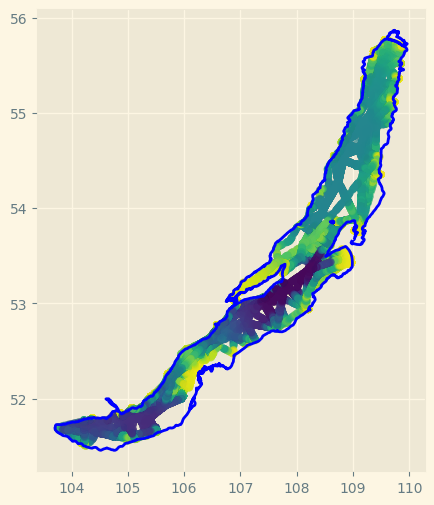

In [34]:
plt.scatter(df['Longitude'], df['Latitude'], s=30, c=df['depth'], marker='o', linewidth=0, alpha=0.1)
plt.plot(obris['long'], obris['lat'], 'b-')

In [45]:
longStep = 0.02
latStep = 0.01

df['long'] = (df['Longitude']/longStep).round()*longStep
df['lat'] = (df['Latitude']/latStep).round()*latStep
df['year'] = df['DateTime'].dt.year

C:\Users\redmi\AppData\Local\Temp\ipykernel_30520\752142288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long'] = (df['Longitude']/longStep).round()*longStep
C:\Users\redmi\AppData\Local\Temp\ipykernel_30520\752142288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'] = (df['Latitude']/latStep).round()*latStep
C:\Users\redmi\AppData\Local\Temp\ipykernel_30520\752142288.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [46]:
func_list = ['mean', 'count']
#func_list = ['mean']
cols_to_calc = {'pCO2Wtr': func_list,
                'pCH4Wtr': func_list,
                'cCO2Wtr': func_list,
                'cCH4Wtr': func_list,
                'dpCO2': func_list,
                'dpCH4': func_list,
                'pCO2Air': func_list,
                'pCH4Air': func_list,
                'depth': ['mean']}
res = df.groupby(['year', 'long', 'lat'], as_index=False).agg(cols_to_calc)
res

year    long    lat     pCO2Wtr           pCH4Wtr         cCO2Wtr  \
                                  mean count        mean count      mean   
0      2013  103.88  51.67         NaN     0    2.648788     3  1.489429   
1      2013  103.88  51.68  504.030811    37    2.838436    52  1.487019   
2      2013  103.90  51.67  483.846000     5    2.619579     7  1.482716   
3      2013  103.90  51.68  443.940000     6    2.763634     6  1.369224   
4      2013  103.92  51.66  476.598333     6    2.741512     6  1.462885   
...     ...     ...    ...         ...   ...         ...   ...       ...   
13478  2024  109.80  55.69  466.136665     9   15.440420     9  1.383091   
13479  2024  109.82  55.69  463.244002     4   17.172978     4  1.373390   
13480  2024  109.82  55.70  478.775523     1   19.037624     1  1.417259   
13481  2024  109.84  55.70  449.176387     3   14.948653     3  1.331032   
13482  2024  109.86  55.70  652.352371    19  525.036206    19  1.419564   

                  cCH4Wtr            dpCO2           dpCH4           pCO2Air  \
      count          mean count       mean count      mean count        mean   
0         3    135.348301     3  95.050024     3  0.747788     3  402.454438   
1        52    145.038937    52  94.245581    52  0.937436    52  402.453944   
2         7    133.855757     7  92.807732     7  0.718579     7  402.454507   
3         6    141.216695     6  54.899927     6  0.862634     6  402.453374   
4         6    140.086326     6  86.183611     6  0.840512     6  402.454596   
...     ...           ...   ...        ...   ...       ...   ...         ...   
13478     9    575.025172     9        NaN     0       NaN     0  410.325152   
13479     4    639.093586     4        NaN     0       NaN     0  410.619580   
13480     1    707.503784     1        NaN     0       NaN     0  411.329054   
13481     3    556.151785     3        NaN     0       NaN     0  412.025452   
13482    19  15243.894482    19        NaN     0       NaN     0  413.357445   

              pCH4Air              depth  
      count      mean count         mean  
0         3       NaN     0 -1263.552000  
1        52       NaN     0 -1284.610231  
2         7       NaN     0 -1209.815286  
3         6       NaN     0 -1287.856000  
4         6       NaN     0 -1133.351333  
...     ...       ...   ...          ...  
13478     9  1.918231     9  -274.480444  
13479     4  1.917792     4  -237.089000  
13480     1  1.917339     1  -196.923000  
13481     3  1.916963     3  -152.826000  
13482    19  1.916033    19   -23.356474  

[13483 rows x 20 columns]

In [47]:
for yr in range(2013, 2026):
    t = res.loc[res['year'] == yr].shape
    print(f'{yr}: {t[0]}')

2013: 1365
2014: 0
2015: 0
2016: 1528
2017: 1753
2018: 1561
2019: 0
2020: 0
2021: 1398
2022: 1712
2023: 2117
2024: 2049
2025: 0


In [48]:
func_list = ['mean', 'std', 'count']

cols_to_calc = {('cCH4Wtr', 'mean'): func_list,
                ('cCO2Wtr', 'mean'): func_list,
                ('depth', 'mean'): ['mean'],
               }
res = res.groupby(['long', 'lat'], as_index=False).agg(cols_to_calc)
res

long    lat      cCH4Wtr                      cCO2Wtr                  \
                            mean                         mean                   
                            mean          std count      mean       std count   
0     103.76  51.69   121.422448          NaN     1  0.795089       NaN     1   
1     103.76  51.70   117.679214          NaN     1  0.830973       NaN     1   
2     103.78  51.69   127.853545          NaN     1  0.814364       NaN     1   
3     103.78  51.70   111.865458          NaN     1  1.063624       NaN     1   
4     103.80  51.69   120.437139          NaN     1  0.814746       NaN     1   
...      ...    ...          ...          ...   ...       ...       ...   ...   
7116  109.86  55.52   437.106082          NaN     1  1.258465       NaN     1   
7117  109.86  55.67   206.294257          NaN     1  1.113005       NaN     1   
7118  109.86  55.68   306.612366          NaN     1  1.066632       NaN     1   
7119  109.86  55.69   424.821573   109.247749     4  0.962329  0.235214     4   
7120  109.86  55.70  7741.220587  5871.251832     5  1.601552  0.692528     5   

           depth  
            mean  
            mean  
0    -372.687950  
1    -409.159250  
2    -479.069000  
3    -612.916500  
4    -604.186600  
...          ...  
7116 -119.229000  
7117 -355.319000  
7118 -297.036071  
7119 -141.357159  
7120  -66.424601  

[7121 rows x 9 columns]

In [49]:
res.to_csv(destData+'.txt',
           sep='\t',
           )

In [ ]:
res.to_csv('all_methane.dat',
           sep='\t'
          )

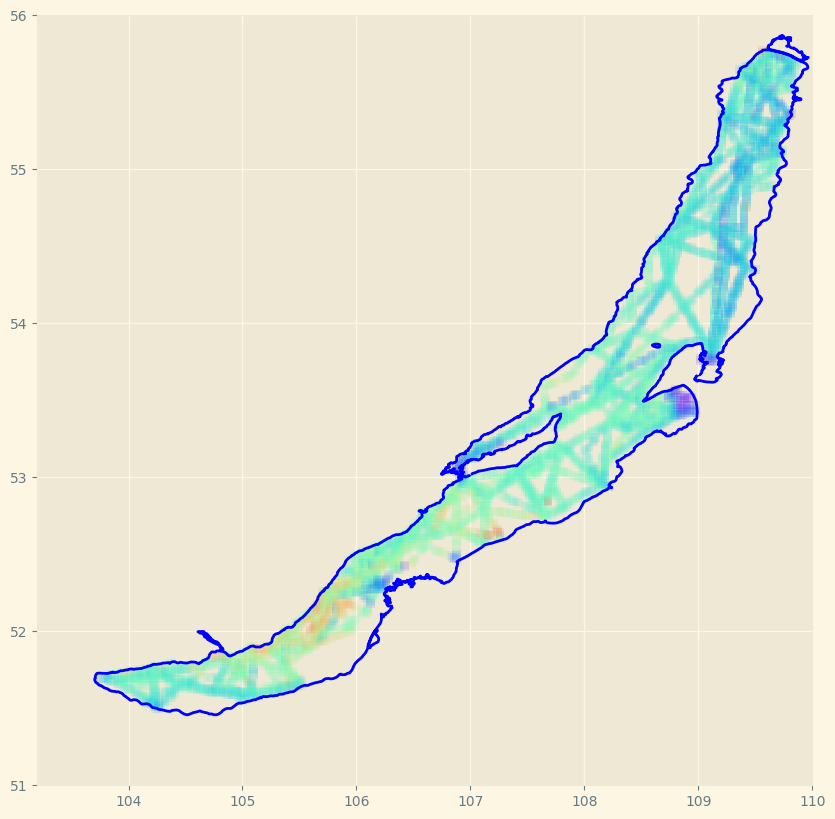

In [50]:
%matplotlib inline
#valMax = res[('cCO2Wtr','mean')].max
plt.rcParams['figure.figsize'] = [10,10]
fig, ax = plt.subplots()
ax.set_xlim(103.2, 110)
ax.set_ylim(51, 56)

# wether this or those
ax.scatter(res['long'], res['lat'], c=res[('cCO2Wtr', 'mean', 'mean')], s=40, marker='s', linewidth=0, cmap='rainbow', alpha=0.1)
ax.plot(obris['long'], obris['lat'], 'b-')

fig.savefig('gis.png')